In [27]:
# 필요한 라이브러리
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [14]:
# 파일 불러오기
df = pd.read_csv("data/서울사고건수(2017~2019).csv")

In [15]:
df

,발생일,사고건수
0,2017-01-01,73
1,2017-01-02,82
2,2017-01-03,88
3,2017-01-04,115
4,2017-01-05,103
...,...,...
1090,2019-12-27,94
1091,2019-12-28,94
1092,2019-12-29,78
1093,2019-12-30,91


In [17]:
#데이터 전처리
df['발생일'] = pd.to_datetime(df['발생일'], format='%Y-%m-%d')

In [4]:
# df_y = df.loc[:,'사고건수']
# df_x = df.drop('사고건수', axis=1)



Text(0, 0.5, 'accident')

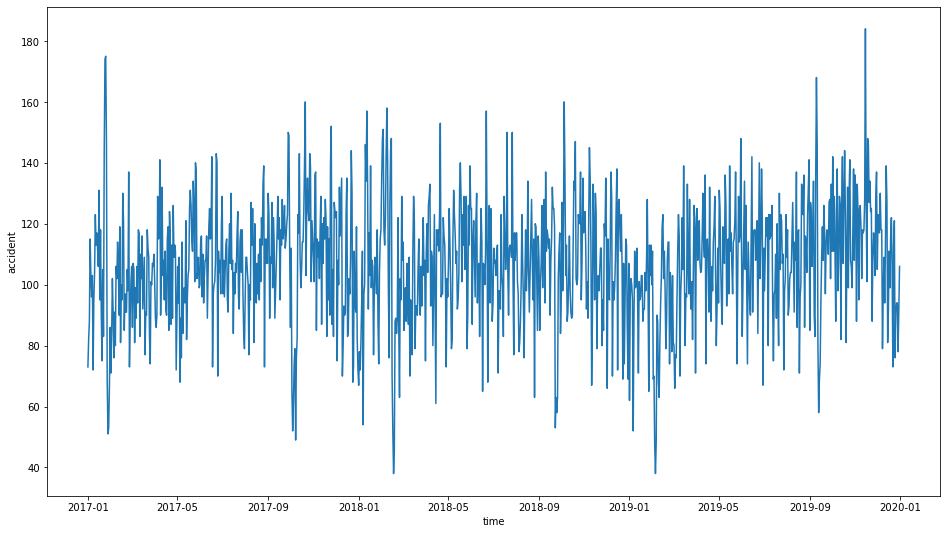

In [18]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['사고건수'], x=df['발생일'])
plt.xlabel('time')
plt.ylabel('accident')

In [19]:
# 데이터 정규화
from sklearn.preprocessing import MinMaxScaler

df.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['사고건수']
df = scaler.fit_transform(df[scale_cols])
df = pd.DataFrame(df)
df.columns = scale_cols

df

,사고건수
0,0.239726
1,0.301370
2,0.342466
3,0.527397
4,0.445205
...,...
1090,0.383562
1091,0.383562
1092,0.273973
1093,0.363014


In [22]:
# 시계열 데이터셋 분리
TEST_SIZE = 950
WINDOW_SIZE = 145

train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]

def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [25]:
from sklearn.model_selection import train_test_split

feature_cols = ['사고건수']
label_cols = ['사고건수']

train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((100, 20, 1), (25, 20, 1))

In [26]:
# 모형학습
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [28]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                                    epochs=200, 
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: 0.1590 
Epoch 1: val_loss improved from inf to 0.20995, saving model to model\tmp_checkpoint.h5
7/7 [==============================] - 2s 97ms/step - loss: 0.1590 - val_loss: 0.2100
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: 0.1337
Epoch 2: val_loss improved from 0.20995 to 0.17993, saving model to model\tmp_checkpoint.h5
7/7 [==============================] - 0s 30ms/step - loss: 0.1337 - val_loss: 0.1799
Epoch 3/200
7/7 [==============================] - ETA: 0s - loss: 0.1086
Epoch 3: val_loss improved from 0.17993 to 0.15010, saving model to model\tmp_checkpoint.h5
7/7 [==============================] - 0s 23ms/step - loss: 0.1086 - val_loss: 0.1501
Epoch 4/200
7/7 [==============================] - ETA: 0s - loss: 0.0832
Epoch 4: val_loss improved from 0.15010 to 0.12033, saving model to model\tmp_checkpoint.h5
7/7 [==============================] - 0s 21ms/step - loss: 0.0832 - val_loss: 0.

In [30]:
model.load_weights(filename)
pred = model.predict(train_feature)

pred.shape

4/4 [==============================] - 0s 4ms/step


(125, 1)

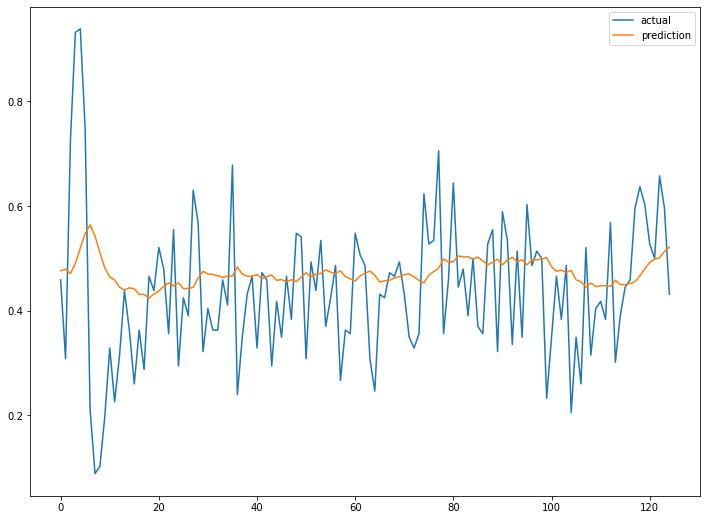

In [32]:
plt.figure(figsize=(12, 9))
plt.plot(train_label, label = 'actual')
plt.plot(pred, label = 'prediction')
plt.legend()
plt.show()